Adapted from: https://github.com/karpathy/micrograd/blob/master/demo.ipynb

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from micrograd.engine import Tensor
from micrograd.nn import MultiLayerPerceptron
from sklearn.datasets import make_moons

np.random.seed(1337)
random.seed(1337)

## Data

In [2]:
X, y = make_moons(n_samples=100, noise=0.1)
y = y * 2 - 1  # make y be -1 or 1

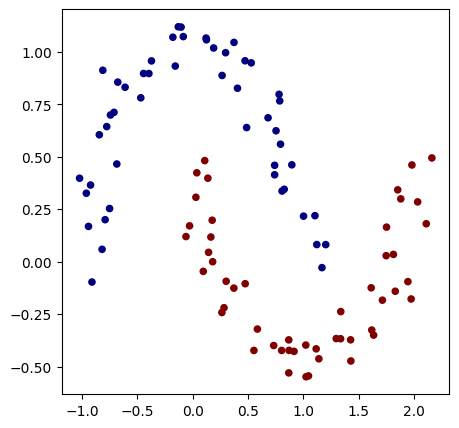

In [3]:
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

## Model

In [4]:
model = MultiLayerPerceptron(2, [16, 16, 1])  # 2-layer neural network
print("No. of params", sum([ p.numel() for p in model.parameters() ]))

No. of params 337


In [5]:
for layer in model.layers:
    print(layer, layer.weights.shape, layer.bias.shape)

Layer(16, act=relu) (2, 16) (16,)
Layer(16, act=relu) (16, 16) (16,)
Layer(1, act=None) (16, 1) (1,)


## Loss

In [6]:
# loss function
def svg_loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [Tensor(xrow) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    losses = [(1 + -yi * scorei)[0].relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = 0.0
    for p in model.parameters():
        reg_loss = reg_loss + (p * p).sum()
    reg_loss = alpha * reg_loss

    total_loss = data_loss  + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

## Training

In [7]:
# params
learning_rate_scldr = lambda k: 1.0 - 0.9 * k / 100
loss = svg_loss
num_steps = 100

In [8]:
total_loss, acc = loss()
print(total_loss, acc)

Tensor(value=1.5810633866346038, shape=(), grad=0.0) [0.48]


In [9]:
# optimization
losses = np.zeros(100, dtype=np.float64)
for k in range(1, num_steps+1):
    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()
    
    learning_rate = learning_rate_scldr(k)

    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    losses[k-1] = total_loss.item

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.item}, accuracy {acc[0] * 100}%")

step 1 loss 1.5810633866346038, accuracy 48.0%
step 2 loss 1.3720359495477035, accuracy 68.0%
step 3 loss 0.9232479143514822, accuracy 74.0%
step 4 loss 0.691552755877881, accuracy 78.0%
step 5 loss 0.3901334665327305, accuracy 84.0%
step 6 loss 0.329914155362951, accuracy 85.0%
step 7 loss 0.2568008868805216, accuracy 88.0%
step 8 loss 0.20609836324603045, accuracy 91.0%
step 9 loss 0.1701093661267046, accuracy 92.0%
step 10 loss 0.16950488085069337, accuracy 92.0%
step 11 loss 0.18745993750475098, accuracy 95.0%
step 12 loss 0.24479351614169823, accuracy 90.0%
step 13 loss 0.1331599559816385, accuracy 97.0%
step 14 loss 0.24527004157055313, accuracy 89.0%
step 15 loss 0.10125079019356749, accuracy 97.0%
step 16 loss 0.12332872497852021, accuracy 95.0%
step 17 loss 0.19522983201243327, accuracy 95.0%
step 18 loss 0.28997850907258016, accuracy 91.0%
step 19 loss 0.38916852767753357, accuracy 86.0%
step 20 loss 0.181156395938085, accuracy 93.0%
step 21 loss 0.12821374068414873, accuracy

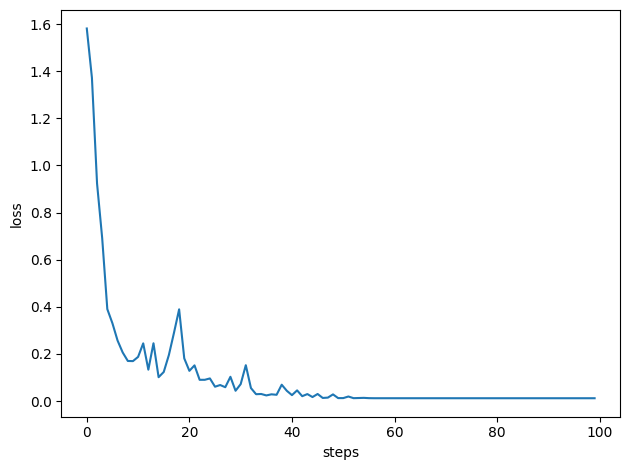

In [10]:
plt.plot(losses)
plt.xlabel("steps")
plt.ylabel("loss")
plt.tight_layout()

## Visualize Decision Boundary

(-2.0221939055140945,
 2.9778060944859055,
 -1.548639298268643,
 1.951360701731357)

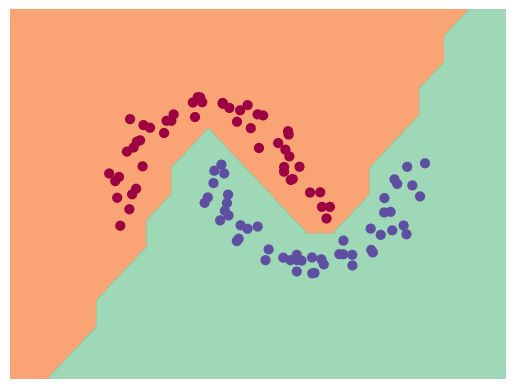

In [11]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [Tensor(xrow) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.axis(False)